In [52]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
from pathlib import Path

import itertools as it
import functools as fn
from tqdm import tqdm

import re
import config as cfg

In [53]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    # 메모리 증가 방식으로 변경  
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4000)])
  except RuntimeError as e:
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    print(e)
  tf.config.experimental.get_memory_info('GPU:0')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [54]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17058056597220578996
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4194304000
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10419822531697493751
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [55]:
data_path = Path('./dataset/data_df.csv')
data_df = pd.read_csv(data_path)
data_df.head()

,code1,code2,similar
0,./dataset/code/problem028/problem028_112.py,./dataset/code/problem085/problem085_1.py,0
1,./dataset/code/problem246/problem246_49.py,./dataset/code/problem246/problem246_125.py,1
2,./dataset/code/problem097/problem097_90.py,./dataset/code/problem204/problem204_26.py,0
3,./dataset/code/problem071/problem071_13.py,./dataset/code/problem071/problem071_94.py,1
4,./dataset/code/problem281/problem281_139.py,./dataset/code/problem300/problem300_109.py,0


# 전처리

In [56]:
def preprocessing(code):
    code = re.sub(r'    ',r'\t ',code)
    code = re.sub(r"#.*\n",'\n',code) # 주석제거
    code = re.sub(r"import.*\n",'',code) # 모듈 참고 안함
    code = re.sub(r'"',r"'",code)
    code = re.sub(r"([\n:(){}\[\]\*\/\%\+\-\,\=.'])",r' \1 ',code)
    code = re.sub(r'\n',r"<n>",code)
    code = re.sub(r'\t',r"<t>",code)
    return code.split()

In [57]:
# # 전처리 테스트
# with open(data_df.code1[0],'r') as f:
#     code1 = f.read()
# with open(data_df.code2[0],'r') as f:
#     code2 = f.read()
    
# code_docs = [code1,code2]

# for i in range(len(code_docs)):
#     code_docs[i] = preprocessing(code_docs[i])

# print(f'{len(code_docs)=}')    
# print(code_docs)

# 단어장 생성

In [58]:
code_path = './dataset/code/'
classes = os.listdir(code_path)
source_list = []
for label in classes:
    filenames = os.listdir(code_path+label)
    for file in filenames:
        source_list.append(code_path+label+'/'+file)

# source_list[145:155]
len(source_list)

45101

In [59]:
print(source_list[478])

./dataset/code/problem004/problem004_124.py


In [60]:
code_docs = []
for src_path in tqdm(source_list):
    with open(src_path,'r',encoding='utf-8') as f:
        code_docs.append(f.read())
len(code_docs)

100%|██████████| 45101/45101 [00:19<00:00, 2345.91it/s]


45101

In [61]:
lens = [len(code_doc) for code_doc in code_docs]
max_len = max(lens)
print(f'{max_len=}')
max_len_id = np.argmax(lens)
print(source_list[max_len_id])
# print(code_docs[max_len_id])

max_len=426657
./dataset/code/problem094/problem094_70.py


In [62]:
print("문장 평균 길이 :",np.mean(lens))
print("문장 최대 길이 :",max(lens))
print("98% 문장 포함 길이 :", np.mean(lens) + 2*np.std(lens))

문장 평균 길이 : 392.9198909115097
문장 최대 길이 : 426657
98% 문장 포함 길이 : 4510.023906204881


In [63]:
max_code = max(code_docs)
print("code_docs.index(max_id)")
print(code_docs.index(max_code))
print()
print("source_list[code_docs.index(max_id)]")
print(source_list[code_docs.index(max_code)])
print()
# print(max_code)

code_docs.index(max_id)
8366

source_list[code_docs.index(max_id)]
./dataset/code/problem056/problem056_51.py



In [64]:
from collections import Counter
import config as cfg

for i in tqdm(range(len(code_docs))):
    code_docs[i] = preprocessing(code_docs[i])

100%|██████████| 45101/45101 [00:09<00:00, 5005.66it/s]


In [65]:
lens = [len(code_doc) for code_doc in code_docs]
max_len = max(lens)
print(f'{max_len=}')
max_len_id = np.argmax([len(code_doc) for code_doc in code_docs])
print(source_list[max_len_id])
# print(code_docs[max_len_id])

max_len=2307
./dataset/code/problem295/problem295_121.py


In [66]:
print("문장 평균 길이 :",np.mean(lens))
print("문장 최대 길이 :",max(lens))
print("98% 문장 포함 길이 :", np.mean(lens) + 2*np.std(lens))

문장 평균 길이 : 163.1383783064677
문장 최대 길이 : 2307
98% 문장 포함 길이 : 463.27556804641875


In [67]:
max_code = max(code_docs)
print("code_docs.index(max_id)")
print(code_docs.index(max_code))
print()
print("source_list[code_docs.index(max_id)]")
print(source_list[code_docs.index(max_code)])
print()
# print(max_code)

code_docs.index(max_id)
8366

source_list[code_docs.index(max_id)]
./dataset/code/problem056/problem056_51.py



In [68]:
counter = Counter()
for code_doc in tqdm(code_docs):
    # code_doc = np.concatenate(code_doc).tolist() # 메모리 부족....
    counter += Counter(code_doc)
most_counter = counter.most_common(cfg.vocab_size-2)
vocab = ['<pad>','<unk>']+[key for key, _ in most_counter]
# print(vocab)
word_to_index = {word:index for index, word in enumerate(vocab)}

100%|██████████| 45101/45101 [01:47<00:00, 421.27it/s] 


In [69]:
print(len(word_to_index))

10000


# input pipe line

In [70]:
del code_docs
del source_list
del most_counter
del counter

In [71]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = cfg.batch_size

In [123]:
def tokenize(path):
    with open(path,'r',encoding='utf8') as f:
        code = f.read()
    words = preprocessing(code)
    code_sequence = [word_to_index[word] if word in word_to_index else word_to_index['<unk>'] for word in words]
    return code_sequence

def make_tensor(paths):
    code_sequences = []
    for path in tqdm(paths):
        code_sequences.append(tokenize(path))
    pad_sequences = keras.preprocessing.sequence.pad_sequences(code_sequences,maxlen=cfg.max_len,truncating='pre')
    return pad_sequences
    
def make_dataset(code1_paths,code2_paths,similar):
    
    code1_tensor = make_tensor(code1_paths)
    print(f"{code1_tensor.shape=}")
    code2_tensor = make_tensor(code2_paths)
    print(f"{code2_tensor.shape=}")
    
    ds = tf.data.Dataset.from_tensor_slices((
        {
            "code1":code1_tensor, "code2":code2_tensor
        },
        {
            "outputs":similar
        }
    ))
    
    # code1_files_ds = tf.data.Dataset.from_tensor_slices(code1_paths)
    # code2_files_ds = tf.data.Dataset.from_tensor_slices(code2_paths)
    # similar_ds = tf.data.Dataset.from_tensor_slices(similar)
    
    # code1_ds = code1_files_ds.map(
    #     make_tensor,
    #     num_parallel_calls=AUTOTUNE
    # )
    # code2_ds = code2_files_ds.map(
    #     make_tensor,
    #     num_parallel_calls=AUTOTUNE
    # )
    # code_ds = tf.data.Dataset.zip((code1_ds,code2_ds))
    # ds = tf.data.Dataset.zip((code_ds,similar_ds))
    
    return ds

In [124]:
code1_files_ds = tf.data.Dataset.from_tensor_slices(data_df['code1'])
for i in code1_files_ds.take(1):
    code1 = tf.io.read_file(i)
    print(type(code1))
    print(code1.numpy().decode('utf8'))

<class 'tensorflow.python.framework.ops.EagerTensor'>
if __name__ == "__main__":
    n, m = map(int, input().split())
    c = list(map(int, input().split()))
    c = sorted(c)

    dp = [[0] * (n + 1)] * m

    for i in range(n + 1):
        dp[0][i] = i
    
    for i in range(1, m):
        for j in range(n + 1):
            dp[i][j] = dp[i - 1][j]
            if j - c[i] >= 0:
                dp[i][j] = min(dp[i][j], dp[i][j - c[i]] + 1)
    print(dp[m-1][n])
        



In [125]:
data_ds = make_dataset(data_df['code1'],data_df['code2'],data_df['similar'])

100%|██████████| 9996/9996 [00:06<00:00, 1549.53it/s]


code1_tensor.shape=(9996, 464)


100%|██████████| 9996/9996 [00:06<00:00, 1567.38it/s]


code2_tensor.shape=(9996, 464)


In [ ]:
print(f"{len(data_ds) = }")
for code, similar in data_ds.take(1):
    print(f"{type(code) = }")
    print(f"{code.keys() = }")
    print(f"{code['code1'].shape = }")
    print(f"{similar = }")

len(data_ds) = 9996
type(code) = <class 'dict'>
code.keys() = dict_keys(['code1', 'code2'])
code['code1'].shape = TensorShape([464])
similar = {'outputs': <tf.Tensor: shape=(), dtype=int64, numpy=0>}


# 데이터셋 나누기

In [ ]:
len(data_ds)

9996

In [ ]:
num_train_ds = int(len(data_ds)*0.8)

train_ds = data_ds.take(num_train_ds)
val_ds = data_ds.skip(num_train_ds)

In [ ]:
print(f"{len(train_ds)=}")
print(f"{len(val_ds)=}")

len(train_ds)=7996
len(val_ds)=2000


# 모델만들기

In [ ]:
from tensorflow.keras.layers import Layer
from tensorflow.keras import Model

## 포지셔널 인코딩(Positional Encoding)

In [ ]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

## 마스킹(making)
- 패딩을 계산하지 않게 해줌.

In [ ]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

## 스케일드 닷-프로덕트 어텐션(Scaled dot-product Attention)

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead)
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

In [ ]:

class MultiHeadAttention(Model):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention,
                                    (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

class EncoderLayer(Model):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, mask):

        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2
    
def Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
    
    input_x = tf.keras.layers.Input(shape=(None, ), name='inputs')
    mask = tf.keras.layers.Input(shape=(1, 1, None), name="padding_mask")
    
    seq_len = tf.shape(input_x)[1]

    # adding embedding and position encoding.
    x = tf.keras.layers.Embedding(input_vocab_size, d_model)(input_x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    x += positional_encoding(maximum_position_encoding, d_model)[:, :seq_len, :]

    x = tf.keras.layers.Dropout(rate)(x)

    for _ in range(num_layers):
        output = EncoderLayer(d_model, num_heads, dff, rate)(x, mask)

    return tf.keras.Model(inputs=[input_x, mask],
                          outputs=output, name="encoder")
    
def make_model(num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):

    encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding)

    input1 = tf.keras.Input(shape=(None,), name="code1")
    input2 = tf.keras.Input(shape=(None,), name="code2")

    code1_enc_padding_mask = keras.layers.Lambda(
        create_padding_mask, output_shape=(1,1,None),
        name = 'cod1_enc_padding_mask'
    )(input1)
    code1 = encoder({'inputs':input1,'padding_mask': code1_enc_padding_mask})
    # code1.shape = (batch_size, inp_seq_len, d_model)
    code2_enc_padding_mask = keras.layers.Lambda(
        create_padding_mask, output_shape=(1,1,None),
        name = 'code2_enc_padding_mask'
    )(input2)
    code2 = encoder({'inputs':input2,'padding_mask': code2_enc_padding_mask})
    # code2.shape = (batch_size, inp_seq_len, d_model)

    outputs = tf.matmul(code1,code2,transpose_a=True)
    outputs = tf.keras.layers.GlobalAveragePooling1D()(outputs)
    outputs = tf.keras.layers.Dropout(rate)(outputs)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid", name="outputs")(outputs)

    return tf.keras.Model(inputs=[input1,input2],
                        outputs=outputs)


In [ ]:
model = Encoder(
    cfg.num_layers,
    cfg.d_model,
    cfg.num_heads,
    cfg.dff,
    cfg.vocab_size,
    cfg.max_len,
)
model.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 tf.compat.v1.shape (TFOpLambda  (2,)                0           ['inputs[0][0]']                 
 )                                                                                                
                                                                                                  
 tf.__operators__.getitem (Slic  ()                  0           ['tf.compat.v1.shape[0][0]']     
 ingOpLambda)                                                                                     
                                                                                            

In [ ]:
def configure_for_performance(ds):
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.repeat()
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

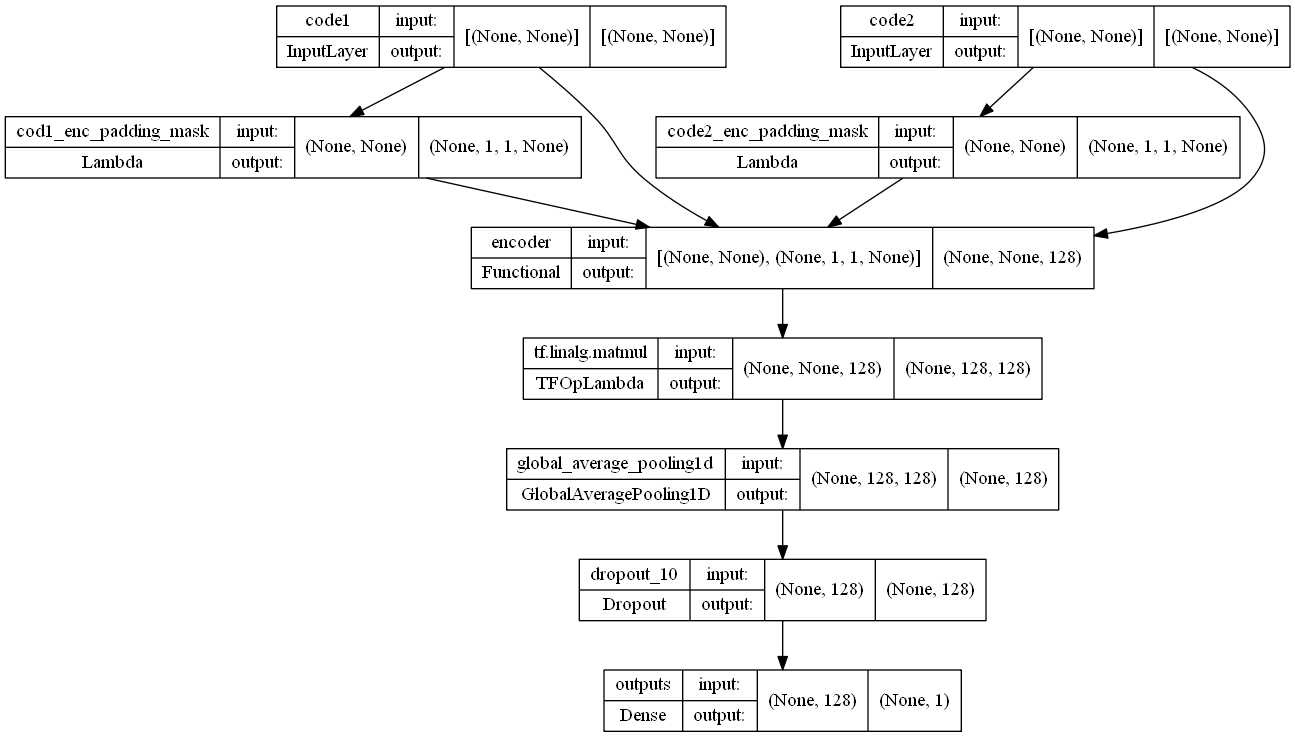

In [ ]:
# make_model(num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
model = make_model(
  cfg.num_layers,
  cfg.d_model,
  cfg.num_heads,
  cfg.dff,
  cfg.vocab_size,
  cfg.max_len,
)

tf.keras.utils.plot_model(
    model, show_shapes=True
)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 code1 (InputLayer)             [(None, None)]       0           []                               
                                                                                                  
 code2 (InputLayer)             [(None, None)]       0           []                               
                                                                                                  
 cod1_enc_padding_mask (Lambda)  (None, 1, 1, None)  0           ['code1[0][0]']                  
                                                                                                  
 code2_enc_padding_mask (Lambda  (None, 1, 1, None)  0           ['code2[0][0]']                  
 )                                                                                            

In [ ]:
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics='accuracy',
                  )

# 모델 훈련

In [ ]:
train_step = len(train_ds)//BATCH_SIZE
val_step = len(val_ds)//BATCH_SIZE

# early stop point
early_stop_point = keras.callbacks.EarlyStopping(patience=50)

# 모델 테스트
filepath = "./model/{epoch:03d}-{val_loss:.4f}"
check_point = keras.callbacks.ModelCheckpoint(
filepath=filepath,
save_best_only = True,
verbose = True
)

hist = model.fit(
    configure_for_performance(train_ds), epochs=1000,
    steps_per_epoch=train_step,
    validation_data=configure_for_performance(val_ds),
    validation_steps=val_step,
    callbacks=[check_point, early_stop_point],
    verbose=1,
)

Epoch 1/1000
249/249 [==============================] - ETA: 0s - loss: 0.6251 - accuracy: 0.6573
Epoch 1: val_loss improved from inf to 0.57325, saving model to ./model\001-0.5733
INFO:tensorflow:Assets written to: ./model\001-0.5733\assets


249/249 [==============================] - 60s 238ms/step - loss: 0.6251 - accuracy: 0.6573 - val_loss: 0.5733 - val_accuracy: 0.7082
Epoch 2/1000
249/249 [==============================] - ETA: 0s - loss: 0.5537 - accuracy: 0.7200
Epoch 2: val_loss improved from 0.57325 to 0.56779, saving model to ./model\002-0.5678
INFO:tensorflow:Assets written to: ./model\002-0.5678\assets


INFO:tensorflow:Assets written to: ./model\002-0.5678\assets


249/249 [==============================] - 59s 235ms/step - loss: 0.5537 - accuracy: 0.7200 - val_loss: 0.5678 - val_accuracy: 0.7399
Epoch 3/1000
249/249 [==============================] - ETA: 0s - loss: 0.4166 - accuracy: 0.8163
Epoch 3: val_loss improved from 0.56779 to 0.50103, saving model to ./model\003-0.5010
INFO:tensorflow:Assets written to: ./model\003-0.5010\assets


INFO:tensorflow:Assets written to: ./model\003-0.5010\assets


249/249 [==============================] - 58s 234ms/step - loss: 0.4166 - accuracy: 0.8163 - val_loss: 0.5010 - val_accuracy: 0.7550
Epoch 4/1000
249/249 [==============================] - ETA: 0s - loss: 0.3034 - accuracy: 0.8723
Epoch 4: val_loss did not improve from 0.50103
249/249 [==============================] - 48s 193ms/step - loss: 0.3034 - accuracy: 0.8723 - val_loss: 0.5885 - val_accuracy: 0.7863
Epoch 5/1000
249/249 [==============================] - ETA: 0s - loss: 0.2099 - accuracy: 0.9183
Epoch 5: val_loss did not improve from 0.50103
249/249 [==============================] - 48s 193ms/step - loss: 0.2099 - accuracy: 0.9183 - val_loss: 0.7393 - val_accuracy: 0.8024
Epoch 6/1000
249/249 [==============================] - ETA: 0s - loss: 0.1509 - accuracy: 0.9431
Epoch 6: val_loss did not improve from 0.50103
249/249 [==============================] - 49s 196ms/step - loss: 0.1509 - accuracy: 0.9431 - val_loss: 0.7119 - val_accuracy: 0.7979
Epoch 7/1000
249/249 [=======

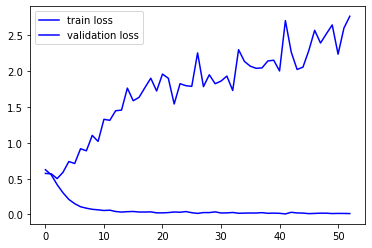

In [ ]:
plt.plot(hist.history['loss'],c='b',label='train loss')
plt.plot(hist.history['val_loss'],c='b',label='validation loss')
plt.legend()
plt.show()

In [ ]:
del model
models = os.listdir('./model/')
print(models[-1])
model = keras.models.load_model('./model/'+models[-1])

003-0.5010


In [ ]:
model.evaluate(val_ds.batch(BATCH_SIZE))

63/63 [==============================] - 134s 771ms/step - loss: 0.4992 - accuracy: 0.7555


[0.4992027282714844, 0.7555000185966492]